In [1]:
from backtest import Backtest, PortfolioAllocationStrategy

from typing import Optional
from datetime import datetime

import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt

import yfinance

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].to_list()
data = yfinance.download(tickers)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


In [3]:
class MyStrategy(PortfolioAllocationStrategy):
    def __init__(self, short_window: int = 20, long_window: int = 100,
                 smoothing: float = 0.5, max_assets: Optional[int] = None):
        super().__init__()
        self.short_window = short_window
        self.long_window = long_window
        self.smoothing = smoothing
        self.max_assets = max_assets

    def get_allocation(self, price_history: pd.DataFrame, wealth: float) -> pd.Series:
        try:
            prev_allocation = self._allocation_for_date(price_history[:-1], wealth)
        except IndexError:
            prev_allocation = None
        try:
            allocation = self._allocation_for_date(price_history, wealth)
        except IndexError:
            allocation = pd.Series(np.zeros(price_history.shape[1]), index=price_history.columns)
            allocation['$'] = 1
        if prev_allocation is not None:
            allocation = (1 - self.smoothing) * allocation + self.smoothing * prev_allocation
        return allocation

    def _allocation_for_date(self, price_history: pd.DataFrame, max_price: Optional[float] = None):
        diff = price_history[-self.short_window:].mean() - price_history[-self.long_window:].mean()
        diff.fillna(0, inplace=True)
        if max_price is not None:
            diff[price_history.iloc[-1] > max_price] = 0
        portfolio = scipy.special.softmax(diff.to_numpy())
        if self.max_assets is not None:
            idx = portfolio.argsort()
            portfolio[idx[:-self.max_assets]] = 0
            portfolio /= portfolio.sum()
        return pd.Series(portfolio, index=diff.index)

In [4]:
strategy = MyStrategy(short_window=25, long_window=150, smoothing=0.6, max_assets=5)
initial_wealth = 30e3
backtest = Backtest(data['Adj Close'], strategy, initial_wealth)
returns = backtest.run(start_date=datetime(2015, 1, 1), min_wealth=initial_wealth * 0.2, weekday=0, verbose=True)

100%|██████████| 335/335 [00:14<00:00, 22.63it/s, date=2022-01-31, portfolio=NVR:37 $:1075, rgmean=0.57%, rmin=-13.99%, rstd=3.77%, wealth=198182.76$]                         


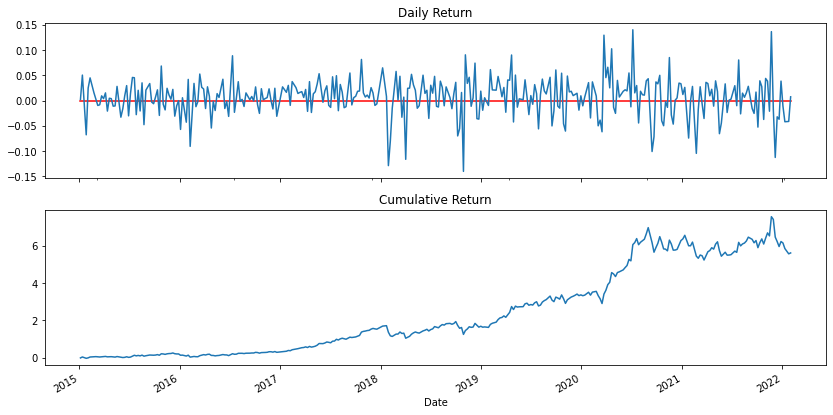

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(14, 7))
ax[0].plot(returns.index, [0] * returns.shape[0], c='r')
returns.plot(title='Daily Return', ax=ax[0], sharex=True)
cumulative = (returns + 1).cumprod() - 1
cumulative.plot(title='Cumulative Return', ax=ax[1], sharex=True)
plt.show()